In [ ]:
!pip install split-folders

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import splitfolders

In [ ]:
path='/content/drive/MyDrive/Vndataset'
print(os.listdir(path))

['GO', 'STOP']


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
splitfolders.ratio(path,ratio=(0.6, 0.4))

Copying files: 227 files [00:03, 68.05 files/s] 


In [ ]:
input_path='/content/output'

In [ ]:
PATH = os.path.join(os.path.dirname(input_path), 'output')

In [ ]:
train_dir = os.path.join(PATH, 'train')
validation_dir = os.path.join(PATH, 'val')

BATCH_SIZE = 32
IMG_SIZE = (160, 160)

train_dataset = tf.keras.utils.image_dataset_from_directory(train_dir,
                                                            shuffle=True,
                                                            batch_size=BATCH_SIZE,
                                                            image_size=IMG_SIZE)
validation_dataset = tf.keras.utils.image_dataset_from_directory(validation_dir,
                                                                 shuffle=True,
                                                                 batch_size=BATCH_SIZE,
                                                                 image_size=IMG_SIZE)

Found 136 files belonging to 2 classes.
Found 91 files belonging to 2 classes.


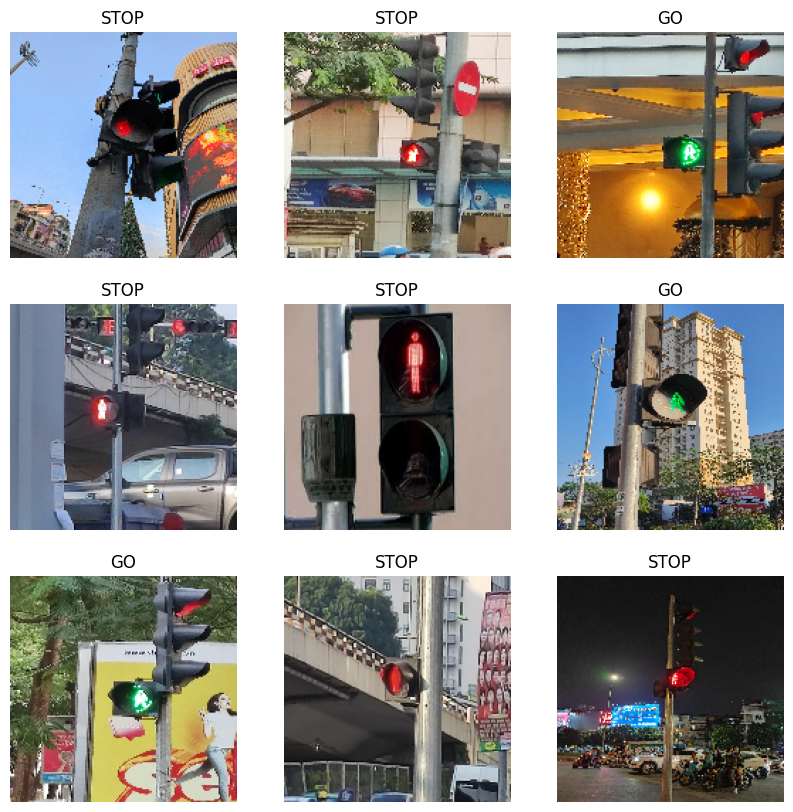

In [ ]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
val_batches = tf.data.experimental.cardinality(validation_dataset)
test_dataset = validation_dataset.take(val_batches // 3)
validation_dataset = validation_dataset.skip(val_batches // 3)

In [ ]:
print('Number of validation batches: %d' % tf.data.experimental.cardinality(validation_dataset))
print('Number of test batches: %d' % tf.data.experimental.cardinality(test_dataset))

Number of validation batches: 2
Number of test batches: 1


In [ ]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
validation_dataset = validation_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip('horizontal'),
  tf.keras.layers.RandomRotation(0.2),
])

In [ ]:
data_augmentation = tf.keras.Sequential([  tf.keras.layers.RandomFlip('horizontal'),  tf.keras.layers.RandomRotation(0.2),])

for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

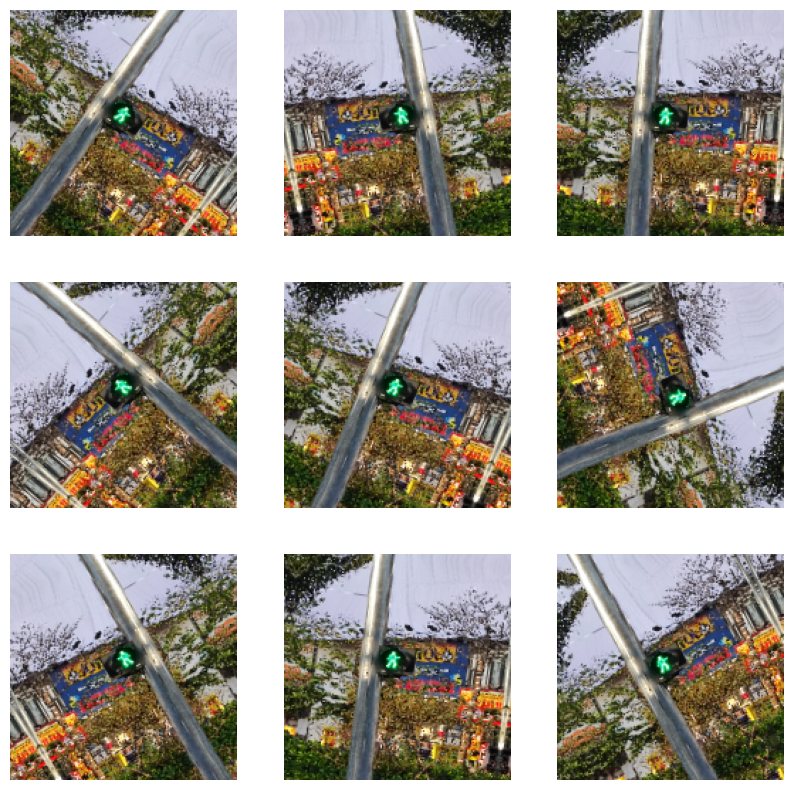

In [ ]:
for image, _ in train_dataset.take(1):
  plt.figure(figsize=(10, 10))
  first_image = image[0]
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
    plt.imshow(augmented_image[0] / 255)
    plt.axis('off')

In [ ]:
preprocess_input = tf.keras.applications.mobilenet.preprocess_input

In [ ]:
# Create the base model from the pre-trained model MobileNet V2
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=False,
                                               weights='imagenet')

In [ ]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)

(32, 5, 5, 1280)


In [ ]:
#freeze convolutional base
base_model.trainable = False

In [ ]:

global_average_layer = tf.keras.layers.GlobalAveragePooling2D()
feature_batch_average = global_average_layer(feature_batch)
print(feature_batch_average.shape)

(32, 1280)


In [ ]:
prediction_layer = tf.keras.layers.Dense(2,activation='softmax')
prediction_batch = prediction_layer(feature_batch_average)
print(prediction_batch.shape)

(32, 2)


In [ ]:
linear=tf.keras.layers.Dense(64)
prediction_lin=linear(prediction_batch)
print(prediction_lin.shape)

(32, 64)


In [ ]:
inputs = tf.keras.Input(shape=(160, 160, 3))
x = data_augmentation(inputs)
x = preprocess_input(x)
x = base_model(x, training=False)
x = tf.keras.layers.Dropout(0.5)(x)
x = global_average_layer(x)
outputs = prediction_layer(x)
model = tf.keras.Model(inputs, outputs)

In [ ]:
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 160, 160, 3)]     0         
                                                                 
 sequential_1 (Sequential)   (None, 160, 160, 3)       0         
                                                                 
 tf.math.truediv_2 (TFOpLam  (None, 160, 160, 3)       0         
 bda)                                                            
                                                                 
 tf.math.subtract_2 (TFOpLa  (None, 160, 160, 3)       0         
 mbda)                                                           
                                                                 
 mobilenetv2_1.00_160 (Func  (None, 5, 5, 1280)        2257984   
 tional)                                                         
                                                           

In [ ]:
base_learning_rate = 0.0001
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
#labels=tf.one_hot(labels,2)

In [ ]:
initial_epochs=10

In [ ]:
history = model.fit(train_dataset,
                    epochs=initial_epochs,
                    validation_data=validation_dataset)

Epoch 1/10


/usr/local/lib/python3.10/dist-packages/keras/src/backend.py:5727: UserWarning: "`sparse_categorical_crossentropy` received `from_logits=True`, but the `output` argument was produced by a Softmax activation and thus does not represent logits. Was this intended?
  output, from_logits = _get_logits(


5/5 [==============================] - 21s 2s/step - loss: 1.4467 - accuracy: 0.3897 - val_loss: 1.2124 - val_accuracy: 0.4068
Epoch 2/10
5/5 [==============================] - 16s 2s/step - loss: 1.2301 - accuracy: 0.4485 - val_loss: 1.0699 - val_accuracy: 0.4915
Epoch 3/10
5/5 [==============================] - 17s 2s/step - loss: 1.0710 - accuracy: 0.4118 - val_loss: 0.9179 - val_accuracy: 0.4746
Epoch 4/10
5/5 [==============================] - 23s 3s/step - loss: 1.0805 - accuracy: 0.4338 - val_loss: 0.8001 - val_accuracy: 0.4746
Epoch 5/10
5/5 [==============================] - 21s 3s/step - loss: 0.9249 - accuracy: 0.4706 - val_loss: 0.8021 - val_accuracy: 0.5424
Epoch 6/10
5/5 [==============================] - 20s 3s/step - loss: 0.9822 - accuracy: 0.4706 - val_loss: 0.8091 - val_accuracy: 0.5085
Epoch 7/10
5/5 [==============================] - 16s 2s/step - loss: 0.9222 - accuracy: 0.5147 - val_loss: 0.7607 - val_accuracy: 0.5254
Epoch 8/10
5/5 [=============================

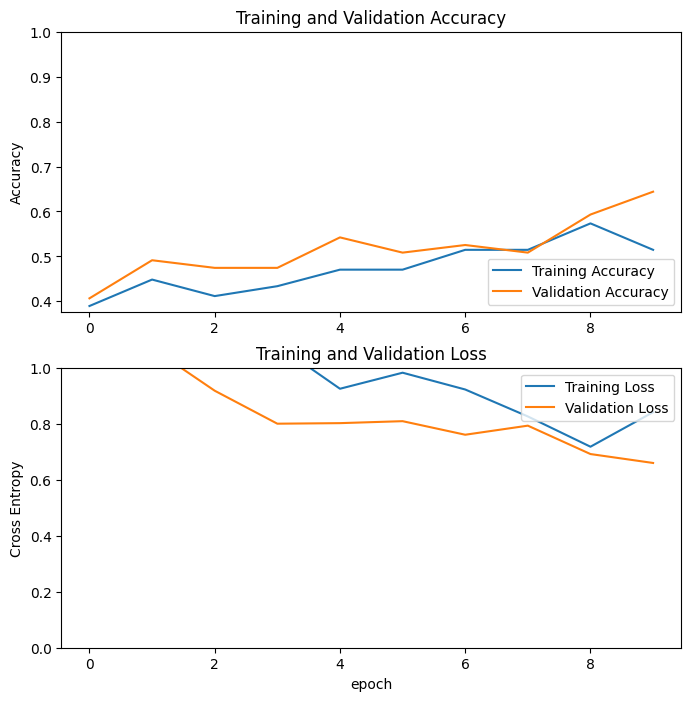

In [ ]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
base_model.trainable = True
# Let's take a look to see how many layers are in the base model
print("Number of layers in the base model: ", len(base_model.layers))

# Fine-tune from this layer onwards
fine_tune_at = 100

# Freeze all the layers before the `fine_tune_at` layer
for layer in base_model.layers[:fine_tune_at]:
  layer.trainable = False

Number of layers in the base model:  154


In [ ]:
model.compile(loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              optimizer = tf.keras.optimizers.Adam(learning_rate=base_learning_rate),
              metrics=[tf.keras.metrics.SparseCategoricalAccuracy(name='accuracy')])

In [ ]:
fine_tune_epochs = 0
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model.fit(train_dataset,
                       epochs=total_epochs,initial_epoch=history.epoch[-1],
                       validation_data=validation_dataset)

Epoch 10/10
5/5 [==============================] - 30s 3s/step - loss: 0.4743 - accuracy: 0.7353 - val_loss: 0.2083 - val_accuracy: 0.9153


In [ ]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

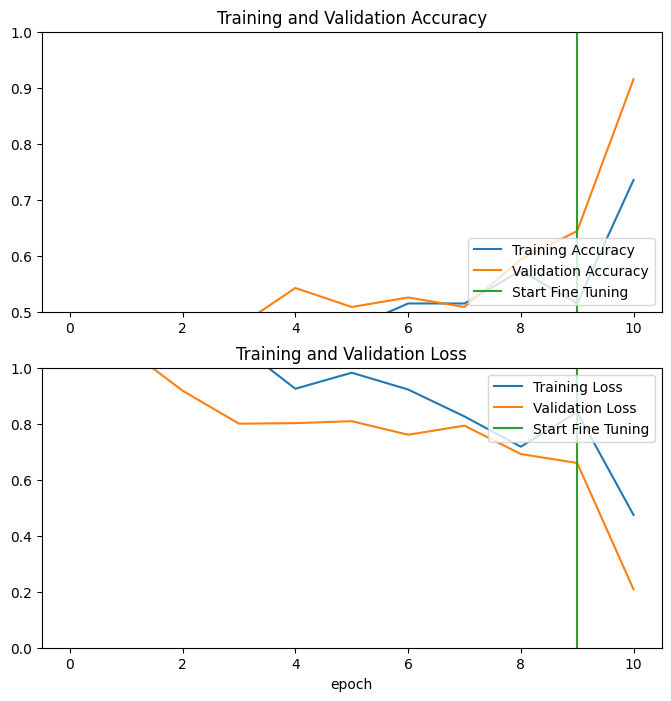

In [ ]:
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0.5, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 1.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [ ]:
from tensorflow import keras

In [ ]:
image_batch, label_batch = test_dataset.as_numpy_iterator().next()

In [ ]:
loss, accuracy = model.evaluate(test_dataset)
print('Test accuracy :', accuracy)

1/1 [==============================] - 5s 5s/step - loss: 0.2116 - accuracy: 0.9062
Test accuracy : 0.90625


In [ ]:
predictions = model.predict_on_batch(image_batch)

In [ ]:
label_batch

array([0, 1, 1, 1, 0, 0, 1, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1, 0, 1, 1, 0,
       0, 0, 0, 0, 1, 0, 1, 0, 1, 1], dtype=int32)

In [ ]:
predictions = tf.where(predictions < 0.5, 0, 1)

In [ ]:
pred_arr=[]
for i in predictions.numpy():
  pred_arr.append(i[1])

In [ ]:
from sklearn.metrics import confusion_matrix

In [ ]:
confusion_matrix(pred_arr,label_batch)

array([[15,  2],
       [ 0, 15]])

In [ ]:
keras_file='linear.h5'
keras.models.save_model(model,keras_file)
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()
open("linear.tflite","wb").write(tflite_model)

<ipython-input-120-8455b0d6c9c0>:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  keras.models.save_model(model,keras_file)


8876268